# Introduction:
This data is based on selling of various kinds of products from four warehouses having a time stamp on them. We will use a number of techniques to analyse the data. The goal is to predict number of order demands using the other feautures. 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
df = pd.read_csv('Historical Product Demand.csv', encoding='utf-8')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Data Cleaning:

We will clean the data by:

-dropping the duplicates

-replacing na values with maximu occured values.


In [73]:
df.shape

(1048575, 5)

In [75]:
df.drop_duplicates(inplace=True)

In [76]:
df.shape

(926152, 5)

In [77]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [78]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [79]:
df=df[pd.to_numeric(df.Order_Demand, errors='coerce').notnull()]
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'])

In [80]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand         int64
dtype: object

# Data exploration:
We will explore the data with some visualisation plots.

Since the first plot with original value was not providing any sognifcant information due to high values of the demand, we have considered the log values of it.


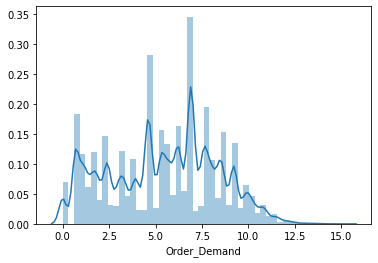

In [81]:
df['Order_Demand'] = np.log1p(df['Order_Demand'])
sns.distplot(df['Order_Demand'])

# 
The distribution of demand is fairly normal.

Now, we will explore the time aspect of the data more. We will split the data according to the time stamp. This will help in figuring monthly, weekly, quartely and yearly distrubtion of demand. wse have plotted some association below.

In [82]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand               float64
dtype: object

In [83]:
df['week_year'] = df['Date'].dt.weekofyear
df['month'] = df['Date'].dt.month
df['quarterly'] = df['Date'].dt.quarter
df['yearly'] = df['Date'].dt.year
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,week_year,month,quarterly,yearly
0,Product_0993,Whse_J,Category_028,2012-07-27,4.615121,30,7,3,2012
1,Product_0979,Whse_J,Category_028,2012-01-19,6.216606,3,1,1,2012
2,Product_0979,Whse_J,Category_028,2012-02-03,6.216606,5,2,1,2012
3,Product_0979,Whse_J,Category_028,2012-02-09,6.216606,6,2,1,2012
4,Product_0979,Whse_J,Category_028,2012-03-02,6.216606,9,3,1,2012


In [84]:
df.yearly.unique()

array([2012, 2011, 2013, 2014, 2015, 2016, 2017])

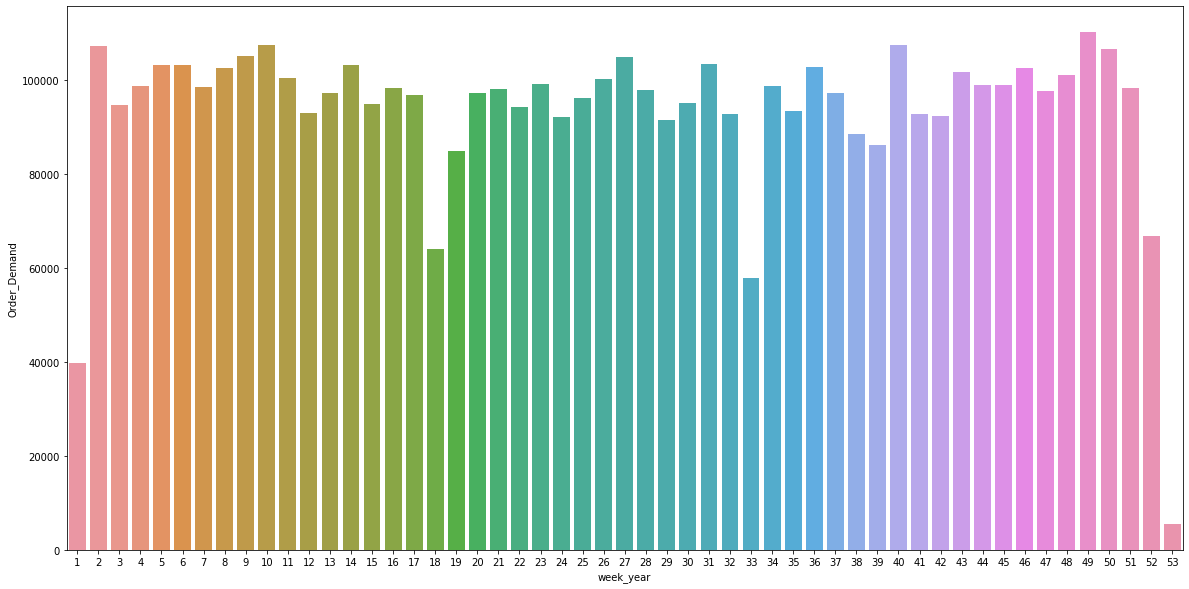

In [95]:
#weekly data
data = df.groupby(['week_year'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(20, 10))

sns.barplot(x="week_year", y="Order_Demand", data=data);

# Some observations:

The figure below shows the monthly distribution of demand. It is bit high for 3rd, 7th and 10th month of a year. 

The quarterly dats is fairly constant without much variation.

The yearly data shows that during 2014 there was high demand for the products.



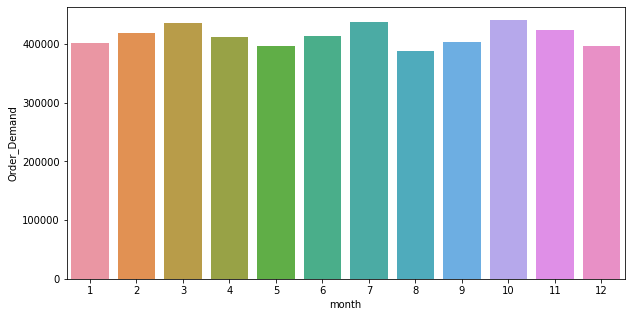

In [99]:
#monthly data
data = df.groupby(['month'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(10, 5))

sns.barplot(x="month", y="Order_Demand", data=data);

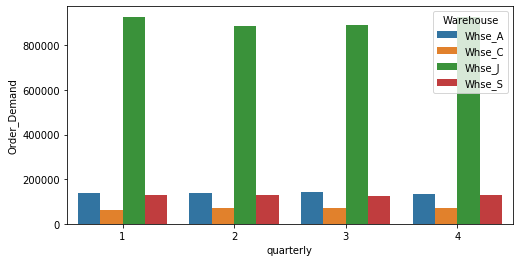

In [102]:
#quartely data split according to warehouse
data = df.groupby(['Warehouse','quarterly'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(8, 4))

sns.barplot(x="quarterly", y="Order_Demand", hue="Warehouse", data=data);

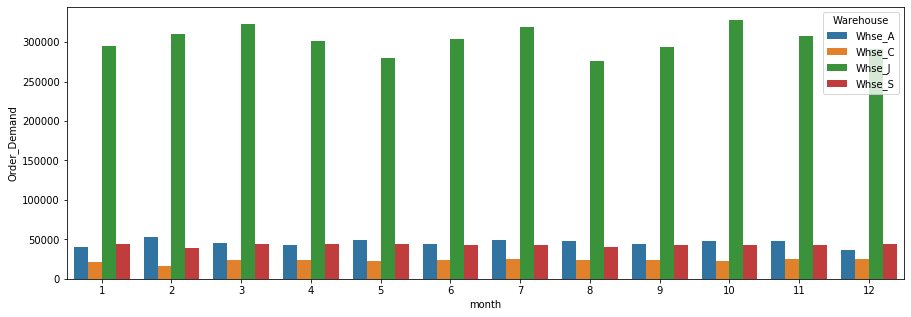

In [85]:
#monthly data split according to warehouse  
data = df.groupby(['Warehouse', 'month'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(15, 5))

sns.barplot(x="month", y="Order_Demand",
            hue="Warehouse", data=data);


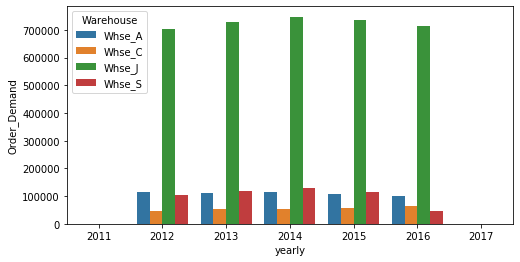

In [103]:
#yearly data split according to warehouse
data = df.groupby(['Warehouse','yearly'])['Order_Demand'].sum().reset_index()
plt.figure(figsize=(8, 4))

sns.barplot(x="yearly", y="Order_Demand", hue="Warehouse", data=data);

# 
Now we will see the data from a different angle. We will see which are the products that have been demanded the most.

From the following table, it is apparent that Product-1359 and product-1295 are two of highest demanded products.


In [113]:
#highest demanded products
data = df.groupby('Product_Code')['Order_Demand'].sum()
data.sort_values(ascending= False)[:10]

Product_Code
Product_1359    101175.437283
Product_1295     60079.696635
Product_1378     54781.490114
Product_1286     51292.740731
Product_1382     50463.042367
Product_1453     48439.626974
Product_1248     48220.560101
Product_1294     48029.483209
Product_1287     47885.783920
Product_1274     47457.106552
Name: Order_Demand, dtype: float64

# Modeling:
We will figure out the demand for product-1359 and product-1295(separately) using other features of data.

We will apply two models: Linear regression and gradient boosting.



In [114]:
df_1359 = df[df['Product_Code'] == 'Product_1359']
cols = ['Order_Demand','week_year', 'month', 'quarterly', 'yearly']
df_1359 = df_1359[cols]

In [115]:
#splitting the data into two subsets: training and test data.
x = df_1359.drop(['Order_Demand'], axis=1).copy()
y = df_1359['Order_Demand'].copy()

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)

# Linear Regression:
## For product: 1359


In [123]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [124]:
y_pred = model.predict(x_test)

In [125]:
df1_1359 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1_1359.head()

,Actual,Predicted
59522,8.517393,9.385925
672201,8.294300,9.390782
260766,10.463132,9.330819
77378,8.006701,9.356278
221833,10.308986,9.330819


In [194]:
#computing the mean square error
def root_meansqrd_error(y_true, y_pred):
    """Calculates RMSE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return ((y_true - y_pred) ** 2).mean() ** .5


y_pred = model.predict(x_test)
rmse = root_meansqrd_error(y_test, y_pred)
round(rmse, 3)

1.909

## Linear regression for product: 1295

In [133]:
df_1295 = df[df['Product_Code'] == 'Product_1295']
cols = ['Order_Demand','week_year', 'month', 'quarterly', 'yearly']
df_1295 = df_1295[cols]

In [134]:
x = df_1295.drop(['Order_Demand'], axis=1).copy()
y = df_1295['Order_Demand'].copy()

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [135]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [195]:
def root_meansqrd_error(y_true, y_pred):
    """Calculates RMSE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return ((y_true - y_pred) ** 2).mean() ** .5


y_pred = model.predict(x_test)
rmse = root_meansqrd_error(y_test, y_pred)

round(rmse, 3)

1.909

# Time series method:

I tried fitting the data to time series model. The idea is to look at the number of products demanded on each date and then forecaste about future demand using this data.

I deleted all the columns except date and demand for products. Then, I clubbed together similar dates and repesented the data in some plots as shown below.

However, it took quite sometime to finish this part of the project. 

In [142]:
df = pd.read_csv('Historical Product Demand.csv', encoding='utf-8')
df.drop_duplicates(inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df=df[pd.to_numeric(df.Order_Demand, errors='coerce').notnull()]
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'])
df=df.drop(['Product_Code', 'Warehouse', 'Product_Category'], axis=1)
df.head()

,Date,Order_Demand
0,2012/7/27,100
1,2012/1/19,500
2,2012/2/3,500
3,2012/2/9,500
4,2012/3/2,500


In [156]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date            datetime64[ns]
Order_Demand             int64
dtype: object

In [178]:
#clubbing together data of same dates and getting the new dataset for the time series analysis
grpbydate = df.groupby(['Date']).size().reset_index(name='counts').sort_values(['Date'],ascending=False)
grpByProdRslt.head(10)

,Date,counts
1726,2017-01-09,3
1725,2017-01-06,16
1724,2017-01-05,20
1723,2017-01-04,8
1722,2017-01-03,3
1721,2017-01-02,1
1720,2016-12-30,31
1719,2016-12-29,62
1718,2016-12-28,389
1717,2016-12-27,431


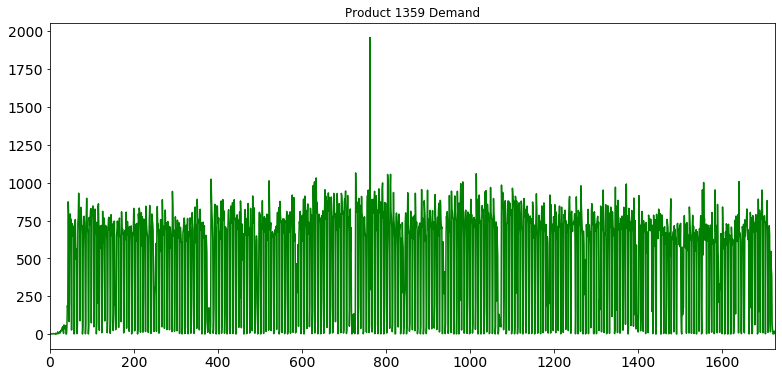

In [176]:
grpbydate.counts.plot(figsize=(13,6), title= 'Product Demand', fontsize=14,color="Green")
plt.show()

In [166]:
!pip install plotly

     |████████████████████████████████| 7.3MB 1.0MB/s eta 0:00:01     |████████████▎                   | 2.8MB 1.0MB/s eta 0:00:05
  Stored in directory: /Users/bibek/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [167]:
import plotly.express as px


In [196]:
fig = px.line(grpbydate, x='Date', y='counts',title= 'Product Demand')
fig.show()

# Gradient boosting:

In [198]:
import xgboost as xgb
model1 = xgb.XGBRegressor(seed=0) 
model1.fit(x_train, y_train) 
print(model1)
y_pred = model1.predict(x_test)
rmse = root_meansqrd_error(y_test, y_pred)

round(rmse, 3)

[13:05:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=1, verbosity=1)


1.909

In [193]:
def root_meansqrd_error(y_true, y_pred):
    """Calculates RMSE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return ((y_true - y_pred) ** 2).mean() ** .5


y_pred = model.predict(x_test)
rmse = root_meansqrd_error(y_test, y_pred)

round(rmse, 3)

1.909

# Conclusion and remarks:
 As we see from the root-mean-squared-values of linear regression and logistic regression for product-1295, both models are equally good though it is notable here that for data having much variation across time, linear regression is not so good model in general despite of its simplicity and reasonability.
 
 I tried to apply time series model. However, I could not fix some bug in the setting. I believe that it will have better accuracy in this case. Some more approaches that could be tried are SVM and random forest techniques.